<a href="https://colab.research.google.com/github/Swarup2608/Heart-Failure-Prediction/blob/main/Heart_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Machine Learning - Classification**


**Course Final Project**

 **Objective**


The main **objective** of my analysis is to focus on prediction of heart failure based on the dataset described

In [3]:
!pip install scikit-learn
!pip install imbalanced-learn
!pip install xgboost
!pip install matplotlib
!pip install seaborn

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [5]:
data = pd.read_csv('./heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


**EDA**

In [6]:
data.isnull().sum()


,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


In [7]:
for feature in data.columns:
    print(feature, ':', len(data[feature].unique()))


age : 47
anaemia : 2
creatinine_phosphokinase : 208
diabetes : 2
ejection_fraction : 17
high_blood_pressure : 2
platelets : 176
serum_creatinine : 40
serum_sodium : 27
sex : 2
smoking : 2
time : 148
DEATH_EVENT : 2


In [8]:
discrete_features, continuous_features = [], []
for feature in data.columns:
    if feature == 'DEATH_EVENT':
        label = ['DEATH_EVENT']
    elif len(data[feature].unique()) >= 10:
        continuous_features.append(feature)
    else:
        discrete_features.append(feature)

print('Discrete: ', discrete_features, '\n', 'Continuous', continuous_features)


Discrete:  ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking'] 
 Continuous ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


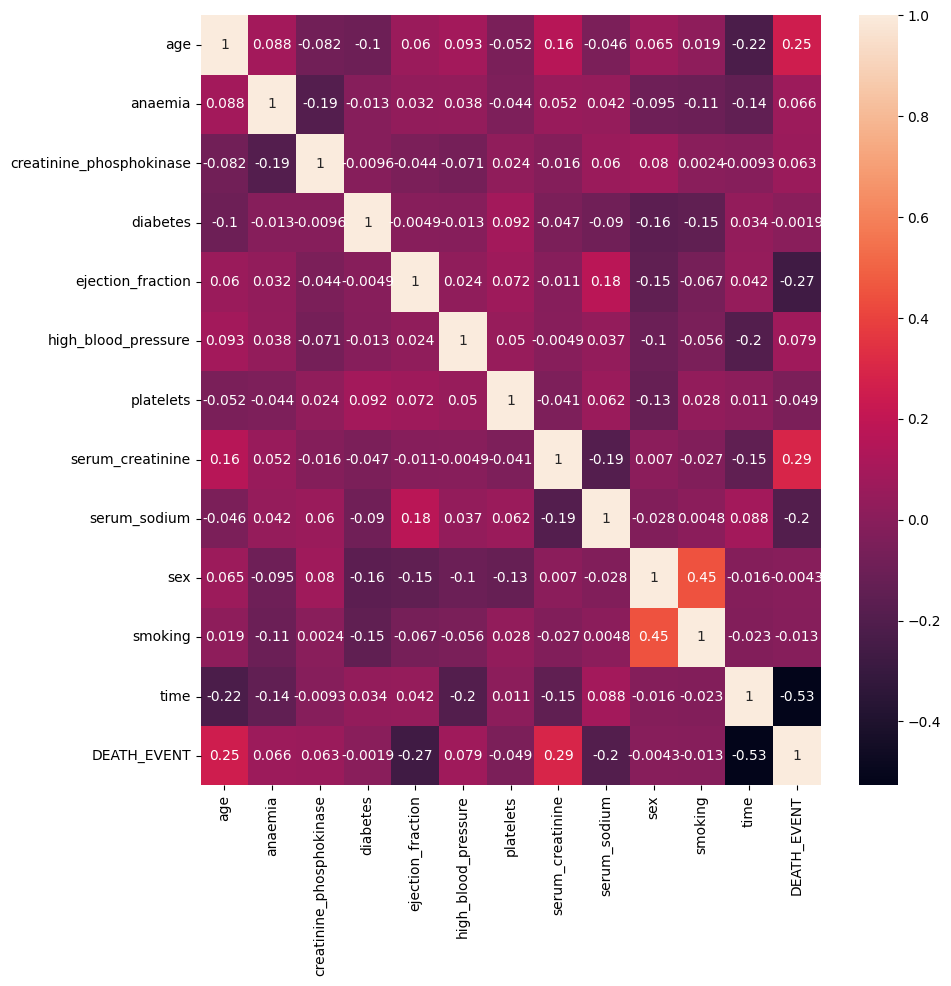

In [9]:
correlation = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()




1.   The correlation matrix for discrete features does not provide any significant insights.
2.   The correlation matrix for continuous features shows an inverse relationship between time and death, suggesting that patients with shorter follow-up times are more likely to experience heart failure.

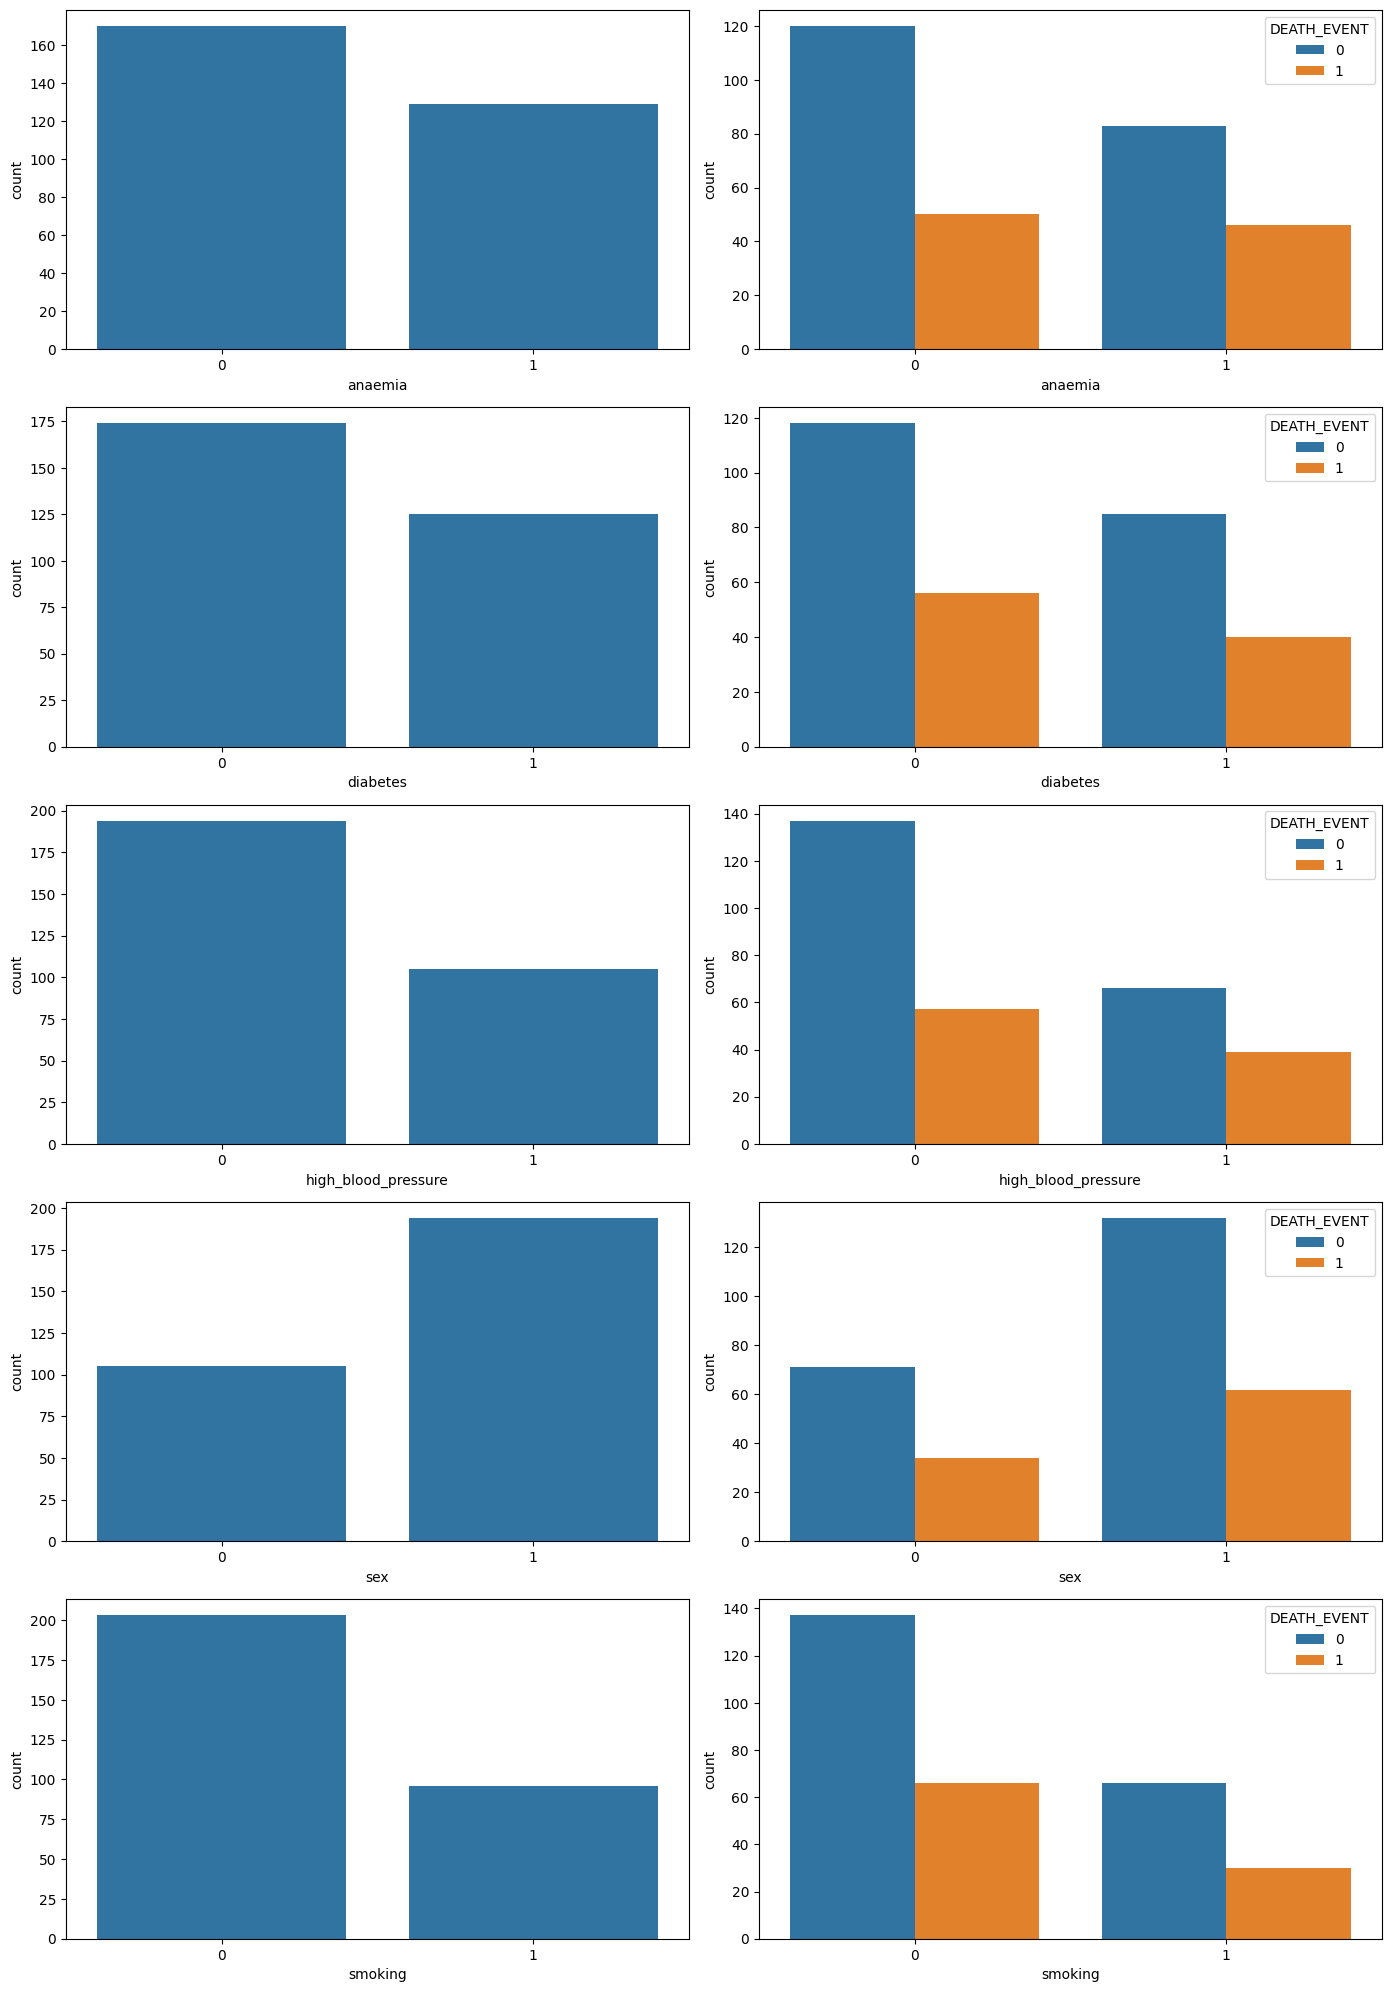

In [10]:
fig, ax = plt.subplots(len(discrete_features), 2, figsize=(14,20))

for i in range(len(discrete_features)):
    sns.countplot(ax=ax[i, 0], x=discrete_features[i], data=data)
    sns.countplot(ax=ax[i, 1], x=discrete_features[i], hue='DEATH_EVENT', data=data)
fig.tight_layout(pad=1)
plt.show()


<Axes: xlabel='DEATH_EVENT', ylabel='count'>

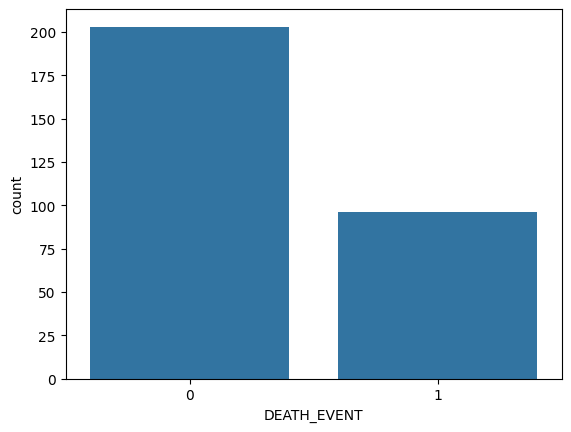

In [11]:
sns.countplot(x='DEATH_EVENT', data=data)


**Observations**

The target variable exhibits an imbalance, so to address this, we will apply cross-validation with an oversampling technique, rather than undersampling, due to the relatively small size of the dataset.

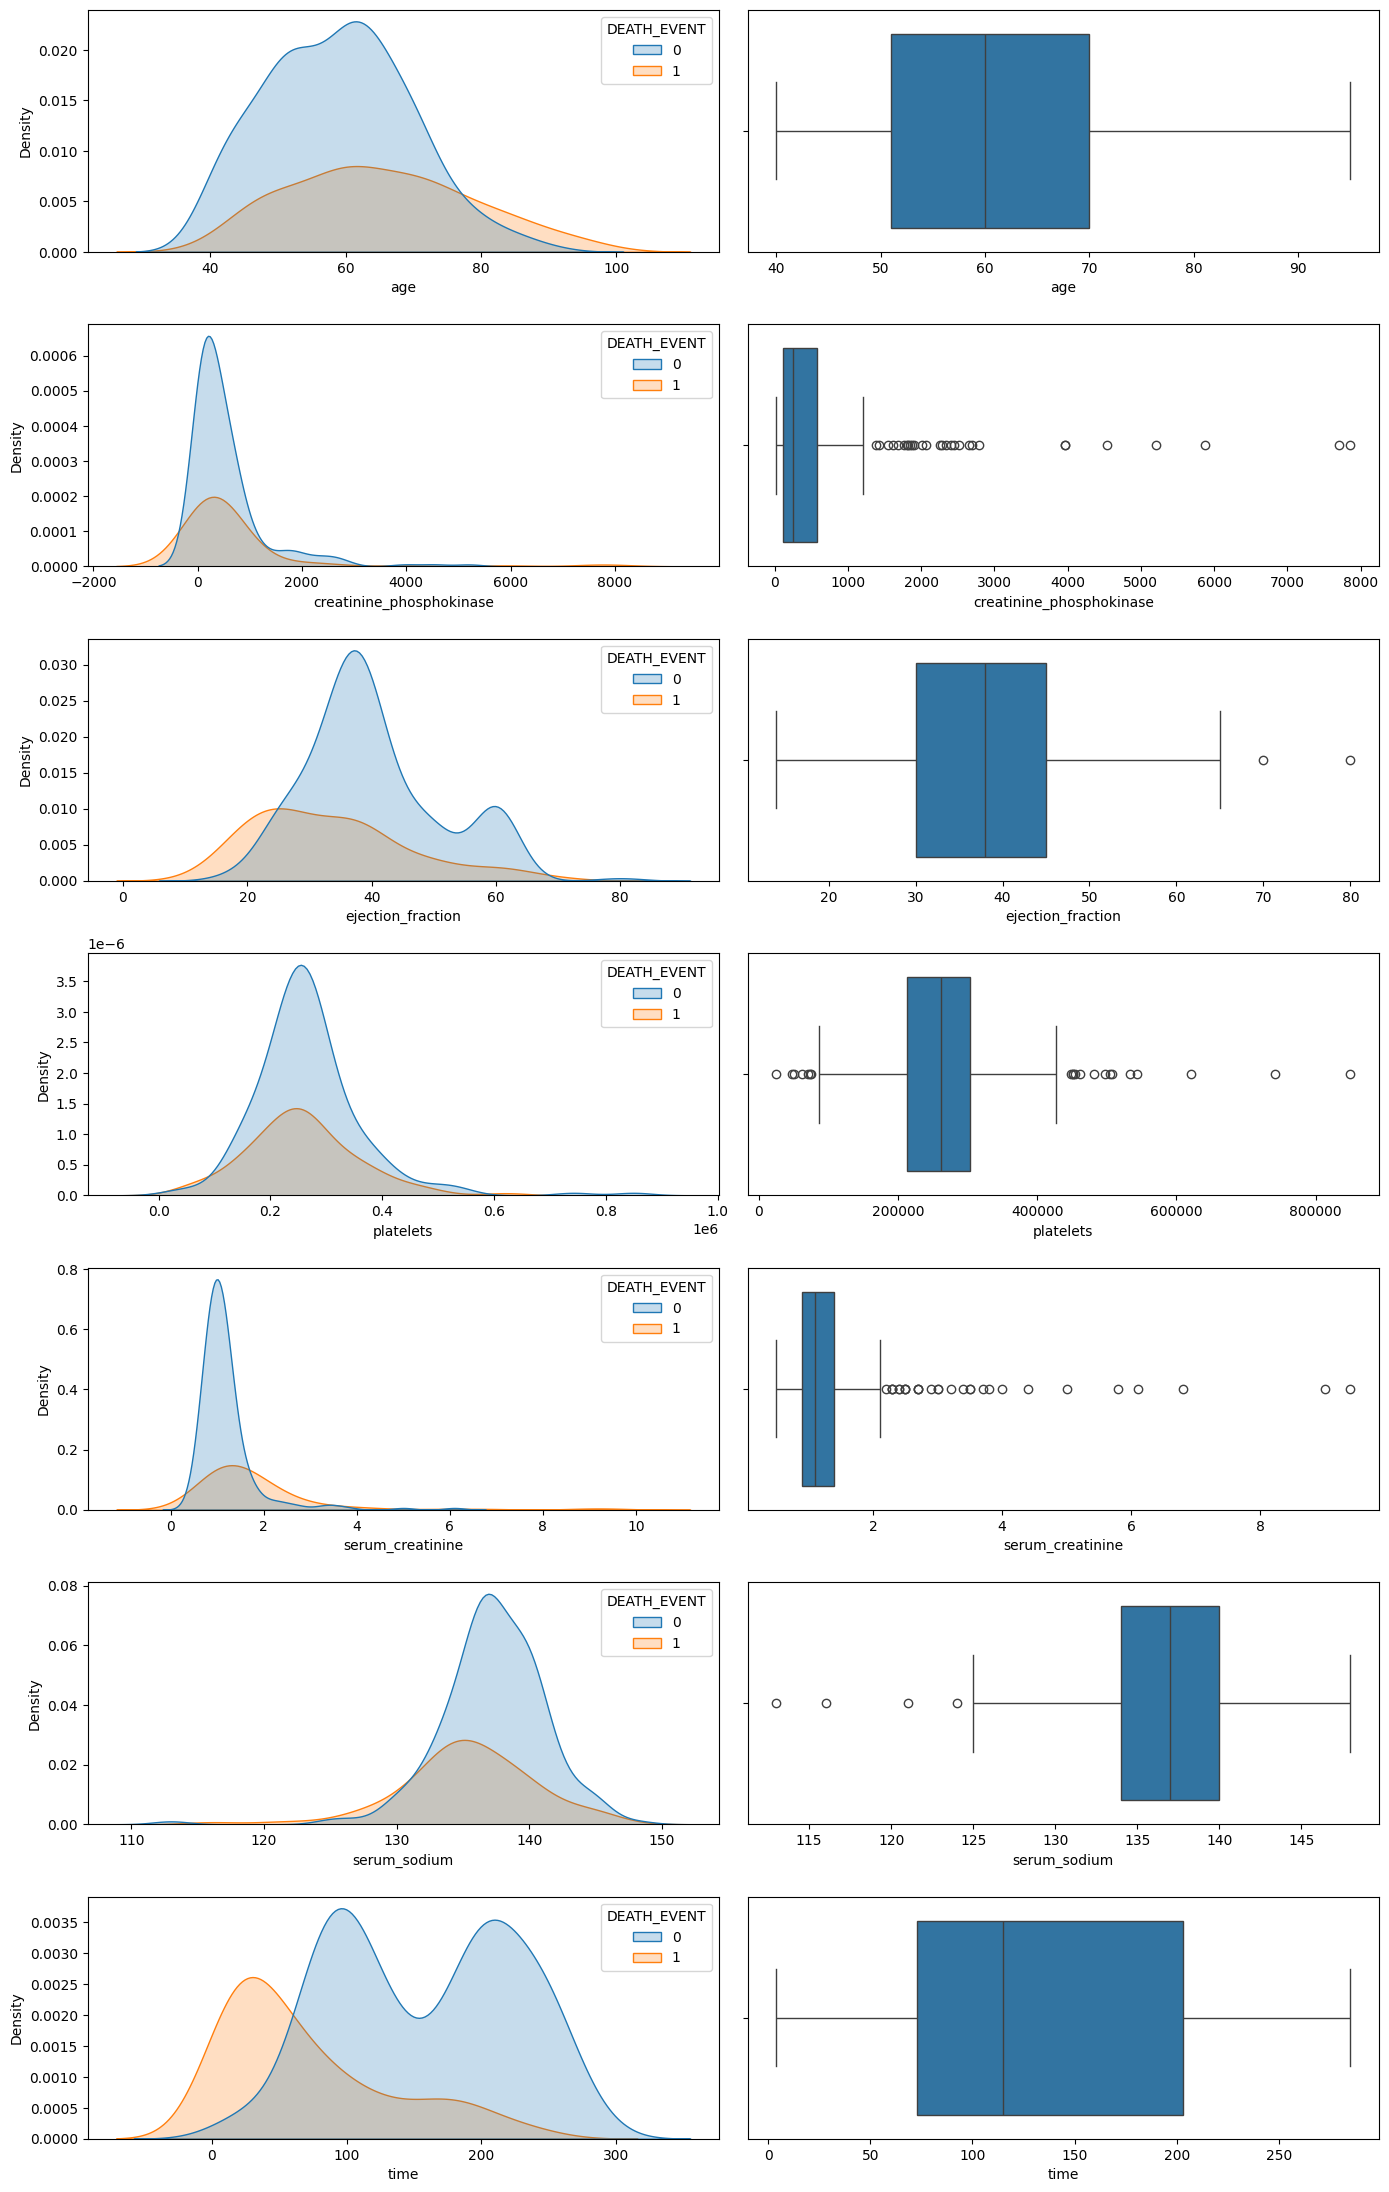

In [12]:
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(14,22))

for i in range(len(continuous_features)):
    sns.kdeplot(ax=ax[i, 0], x=continuous_features[i], hue='DEATH_EVENT', data=data, fill = True)
    sns.boxplot(ax=ax[i, 1], x=continuous_features[i], data=data)
fig.tight_layout(pad=1)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import chi2, SelectFromModel, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
import xgboost

In [14]:
best_features = SelectKBest(chi2, k=10)
features_ranking = best_features.fit(data.drop(['DEATH_EVENT'], axis=1), data['DEATH_EVENT'])
ranking_dictionary = {}
for i in range(len(features_ranking.scores_)):
    ranking_dictionary[data.columns[i]] = round(features_ranking.scores_[i], 3)

asc_sort = sorted(ranking_dictionary.items(), key = lambda kv:(kv[1], kv[0]))

for i, j in asc_sort:
    print(i, ':', j)

diabetes : 0.001
sex : 0.002
smoking : 0.032
anaemia : 0.747
high_blood_pressure : 1.222
serum_sodium : 1.618
serum_creatinine : 19.814
age : 44.619
ejection_fraction : 79.073
creatinine_phosphokinase : 1897.315
time : 3826.893
platelets : 26135.772


In [18]:
feature_model = SelectFromModel(Lasso(alpha=0.05, random_state=0))
feature_model.fit(data.drop(['DEATH_EVENT'], axis=1), data['DEATH_EVENT'])


SelectFromModel(estimator=Lasso(alpha=0.05, random_state=0))

In [19]:
mask = feature_model.get_support()
for i in range(len(mask)):
    if not mask[i]:
        print(data.drop(['DEATH_EVENT'], axis=1).columns[i])


anaemia
diabetes
high_blood_pressure
platelets
sex
smoking


Observations

*   Based on the EDA and feature selection process, the features anaemia, diabetes, age, sex, and smoking have minimal contribution.

*   The key features to focus on are platelets, time, creatinine_phosphokinase, and ejection_fraction.




In [20]:
X = data.drop(['DEATH_EVENT'], axis=1)
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape)

(239, 12) (60, 12)


In [21]:
features_with_outliers = ['creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'serum_sodium']


In [22]:
lof = LocalOutlierFactor()
outlier_rows = lof.fit_predict(X_train)

mask = outlier_rows != -1
X_train, y_train = X_train[mask], y_train[mask]

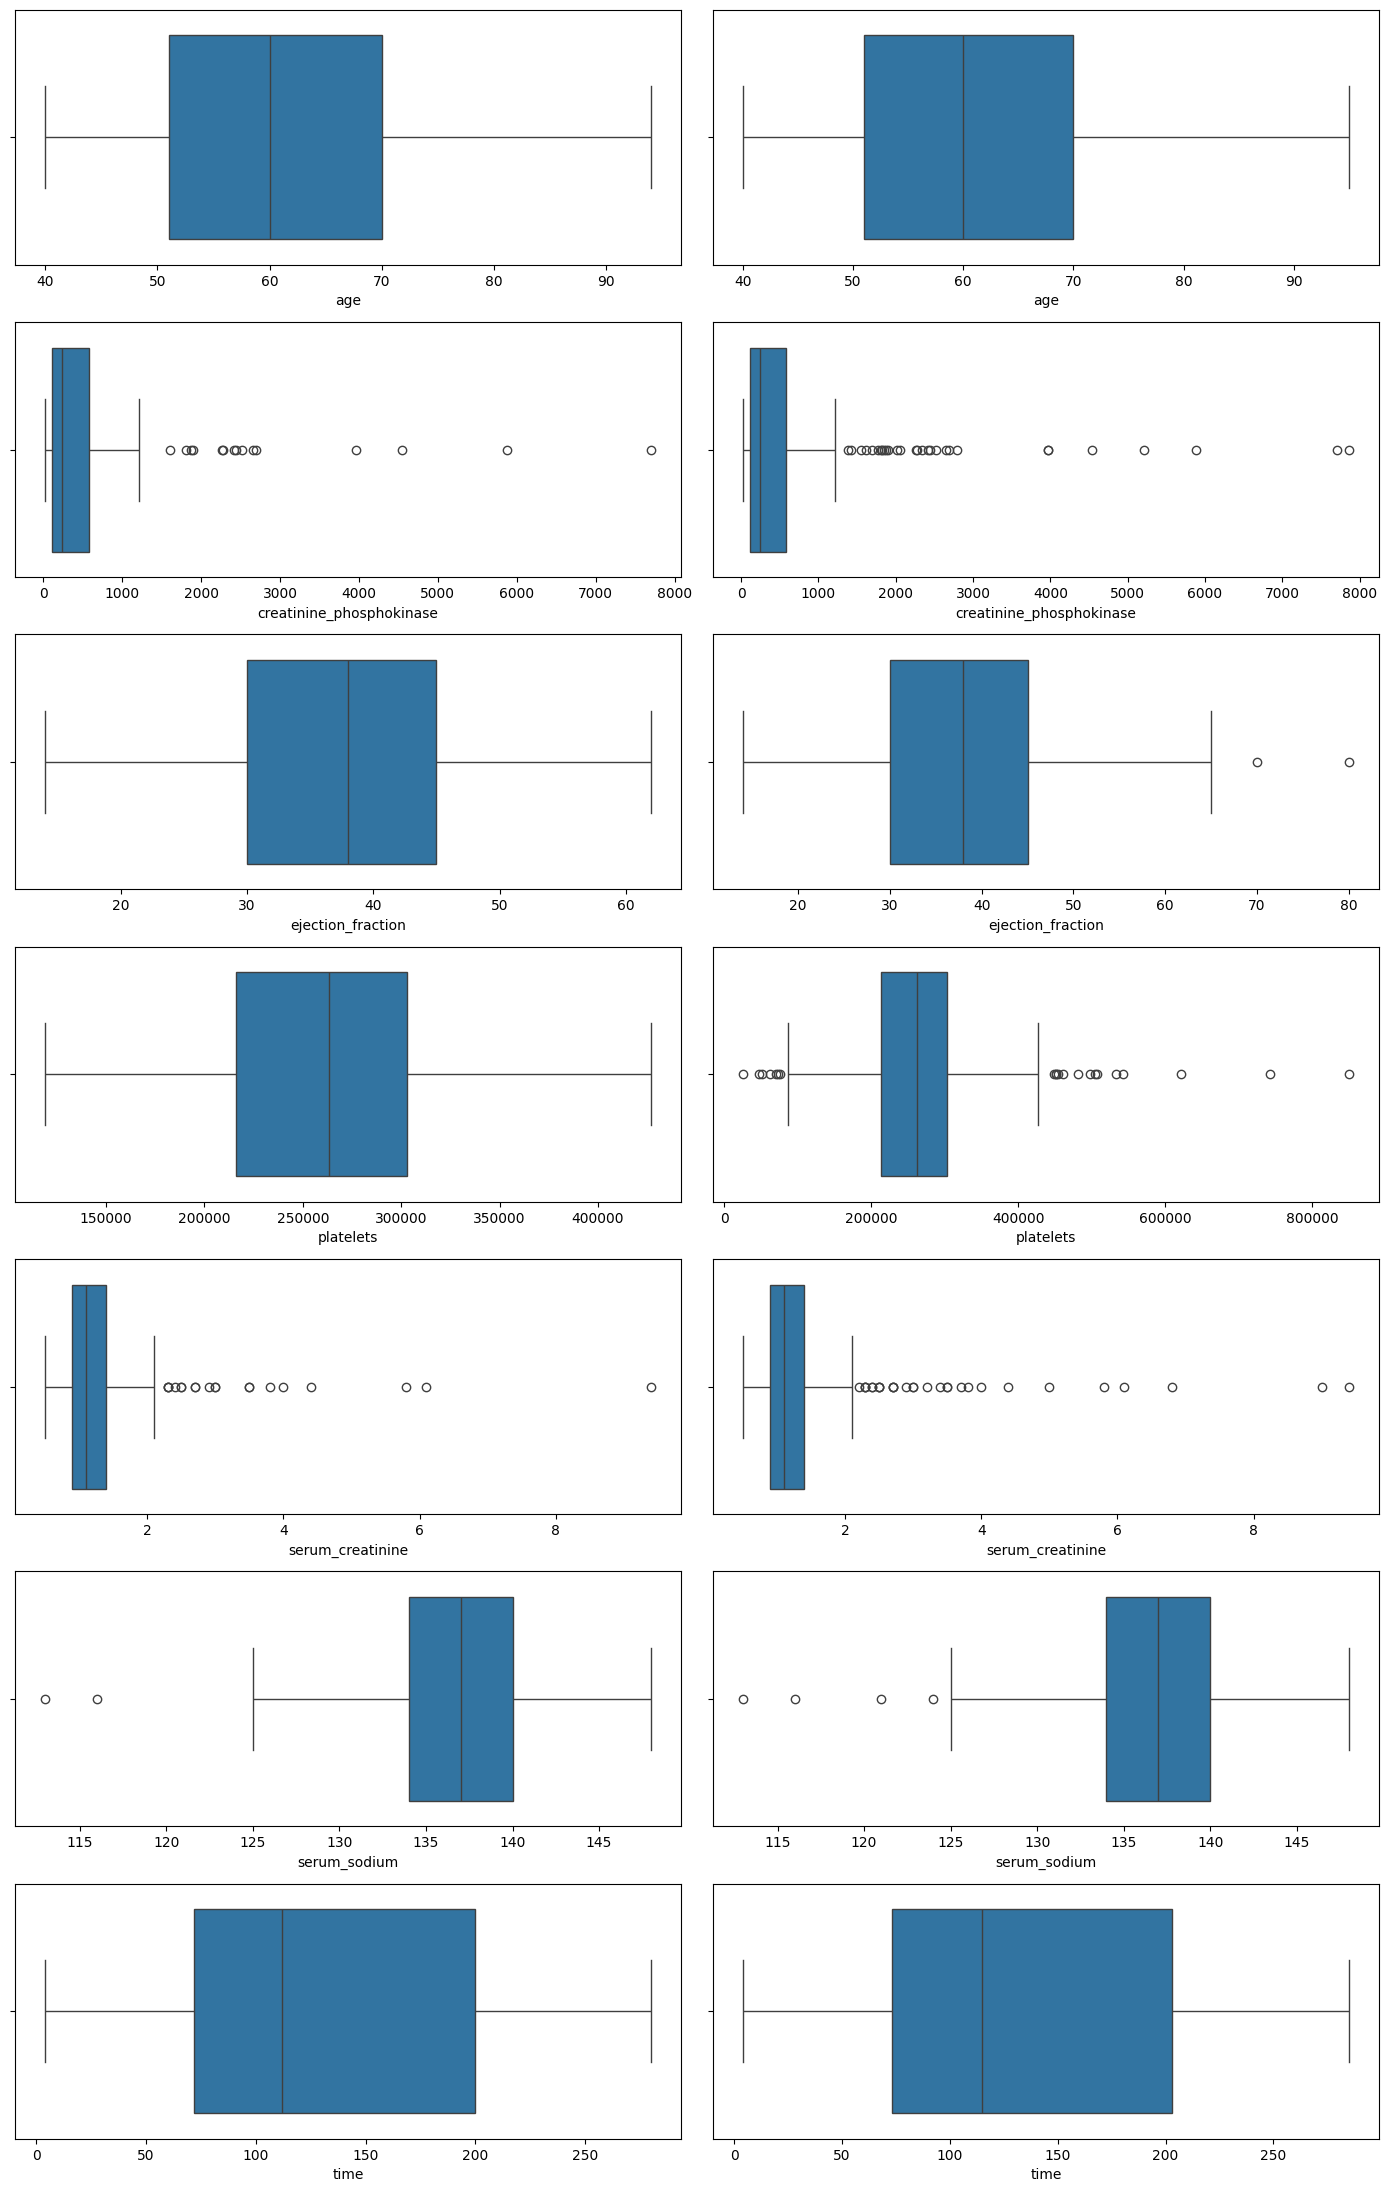

In [23]:
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(14,22))

for i in range(len(continuous_features)):
    sns.boxplot(ax=ax[i, 0], x=continuous_features[i], data=X_train)
    sns.boxplot(ax=ax[i, 1], x=continuous_features[i], data=data)
fig.tight_layout(pad=1)
plt.show()

**Model Building with SMOTE**

The accuracy of Logistic Regression is: 81.66666666666667 %
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        37
           1       0.77      0.74      0.76        23

    accuracy                           0.82        60
   macro avg       0.81      0.80      0.80        60
weighted avg       0.82      0.82      0.82        60



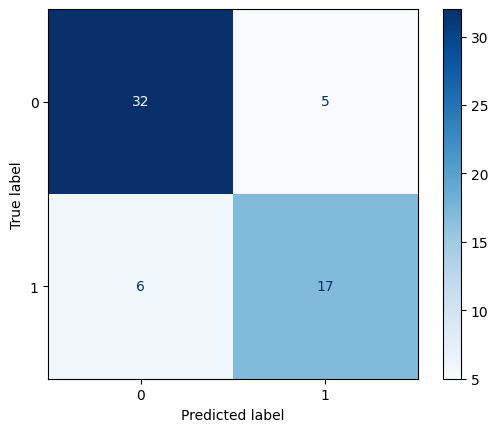

In [24]:
X = data[['ejection_fraction', 'serum_creatinine', 'time']]
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lof = LocalOutlierFactor()
outlier_rows = lof.fit_predict(X_train)

mask = outlier_rows != -1
X_train, y_train = X_train[mask], y_train[mask]

oversample = SMOTE(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Assuming X_train, X_test, y_train, and y_test are already defined
model = LogisticRegression()
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print("The accuracy of Logistic Regression is:", accuracy, "%")

# Print the classification report
print(classification_report(y_test, y_pred))

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Customize the color map as needed
plt.show()

The accuracy of Random Forest is: 83.33333333333334 %
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        37
           1       0.84      0.70      0.76        23

    accuracy                           0.83        60
   macro avg       0.84      0.81      0.82        60
weighted avg       0.83      0.83      0.83        60



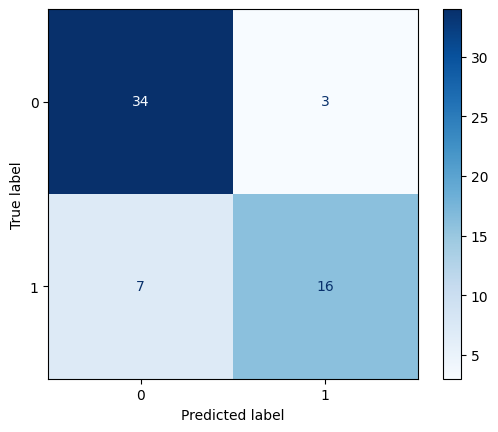

In [25]:
# Assuming X_train, X_test, y_train, and y_test are already defined
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print("The accuracy of Random Forest is:", accuracy, "%")

# Print the classification report
print(classification_report(y_test, y_pred))

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Customize the color map as needed
plt.show()

The accuracy of Gradient Boosting is: 86.66666666666667 %
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        37
           1       0.83      0.83      0.83        23

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



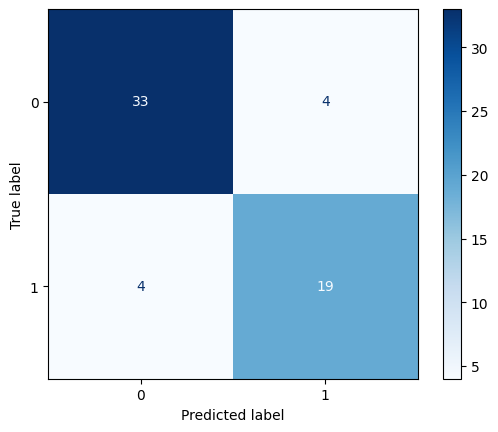

In [26]:
# Assuming X_train, X_test, y_train, and y_test are already defined
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print("The accuracy of Gradient Boosting is:", accuracy, "%")

# Print the classification report
print(classification_report(y_test, y_pred))

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Customize the color map as needed
plt.show()


Logistic Regression Accuracy :  82% Recall : 81%

---
Random Forest Accuracy :  85% Recall : 83%

---

Graduent Boosting Accuracy :  90% Recall : 89%


# **Best Model to choose**


Gradient Boosting demonstrates superior performance compared to other algorithms when evaluated based on both accuracy and recall metrics. However, the recall score is emphasized in this context due to the critical nature of the dataset, which focuses on predicting heart failure. Given the potential severity of false negatives—where cases of heart failure might be incorrectly classified as non-critical—the recall metric becomes a crucial indicator of the model's effectiveness. By prioritizing recall, the Gradient Boosting model ensures a higher likelihood of correctly identifying true positive cases, thereby minimizing the risks associated with undetected heart failure and enhancing the model's reliability for medical decision-making.

# **Future Scope**

1. **Conduct In-Depth Data Analysis:** Perform a comprehensive analysis of the dataset to uncover underlying patterns, trends, and relationships that may not be immediately evident, thereby gaining deeper insights into the data.

2. **Create Additional Derived Features:** Engineer new features based on the insights from the analysis to enrich the dataset and enhance the predictive power of the model.

3. **Experiment with Diverse Models:** Explore various classification algorithms and ensemble methods to evaluate their performance and identify the most suitable model for the task.

4. **Optimize Model Parameters:** Implement hyperparameter tuning techniques, such as grid search or random search, to refine model parameters and achieve optimal performance.

5. **Validate Model Robustness:** Perform cross-validation to assess the model's reliability, robustness, and ability to generalize to unseen data.

6. **Apply Feature Selection Techniques:** Use feature selection methods to pinpoint the most influential variables contributing to the predictions, improving model interpretability and efficiency.

7. **Leverage Advanced Techniques:** Incorporate advanced methodologies, such as deep learning models, to push the boundaries of prediction accuracy and handle complex data patterns.

8. **Evaluate Preprocessing Techniques:** Investigate the effect of different data preprocessing methods, such as normalization, standardization, or imputation strategies, on model performance to identify the most effective approach.